In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
web_info_df = pd.read_excel("/Users/ljohnson/repos/livjab/spoofmail/website_privacy.xlsx", sheet_name="Sheet1")
web_info_df.head()

,Country_Rank,Website,Trustworthiness,Avg_Daily_Visitors,Child_Safety,Avg_Daily_Pageviews,Privacy,Traffic_Rank,Daily_Pageviews,Daily_Pageviews_per_user_percentage,Location,Hosted_by,Registrant,Registrar,country,Privacy_policy
0,1,www.google.com,Excellent,518 108 189,Excellent,4 186 314 171,Excellent,1,8.448960,33.9,United States,Google Inc.,DNS Admin (Google Inc.),MARKMONITOR INC.,United States,"Privacy Policy Last modified: December 18, 201..."
1,2,www.youtube.com,Excellent,506 457 282,Excellent,2 679 159 025,Excellent,2,5.934720,3.8,United States,Google Inc.,DNS Admin (Google Inc.),MARKMONITOR INC.,United States,"Last modified: June 24, 2013 (view archived ve..."
2,3,www.facebook.com,Excellent,270 071 255,Good,1 082 985 733,Excellent,3,2.046720,-8.2,Ireland,Facebook,"Domain Administrator (Facebook, Inc.)",MARKMONITOR INC.,United States,Data Policy\nThis policy describes the informa...
3,4,www.reddit.com,Excellent,60 614 015,Excellent,649 176 107,Excellent,9,1.390080,0.8,United States,Fastly,Domain Administrator (Reddit Inc),GANDI SAS,United States,"Reddit Privacy Policy\nEffective June 8, 2018...."
4,5,www.amazon.com,Excellent,48 820 414,Excellent,399 350 988,Excellent,11,0.770688,-1.5,United States,Amazon Technologies Inc.,"Hostmaster, Amazon Legal Dept. (Amazon Technol...",MARKMONITOR INC.,United States,Amazon Privacy Notice\n\nLast updated: August ...


In [31]:
web_info_df["Privacy"].value_counts()

Excellent         46
Poor               1
Unsatisfactory     1
Good               1
Name: Privacy, dtype: int64

In [32]:
# target will be privacy column
# will change to 1/0 (excellent/not excellent)

web_info_df["Privacy"] = web_info_df["Privacy"].replace({"Excellent": 1, "Good": 0, "Unsatisfactory": 0, "Poor": 0})
web_info_df["Privacy"].value_counts()

1    46
0     3
Name: Privacy, dtype: int64

In [39]:
import re

def tokenizer(text):
    sample = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = sample.lower().split()
    
    return tokens

In [40]:
web_info_df['tokens'] = web_info_df['Privacy_policy'].apply(tokenizer)
web_info_df['tokens'].head()

0    [privacy, policy, last, modified, december, 18...
1    [last, modified, june, 24, 2013, view, archive...
2    [data, policythis, policy, describes, the, inf...
3    [reddit, privacy, policyeffective, june, 8, 20...
4    [amazon, privacy, noticelast, updated, august,...
Name: tokens, dtype: object

In [42]:
from collections import Counter

word_counts = Counter()

web_info_df['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('to', 6123),
 ('and', 5833),
 ('the', 4952),
 ('you', 4818),
 ('your', 4012),
 ('or', 3710),
 ('information', 3520),
 ('of', 3356),
 ('we', 3235),
 ('our', 2437)]

In [43]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [44]:
wc = count(web_info_df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
45,to,49,6123,1.0,0.037780,0.037780,1.000000
359,and,49,5833,2.0,0.035990,0.073770,1.000000
354,the,49,4952,3.0,0.030555,0.104325,1.000000
418,you,48,4818,4.0,0.029728,0.134052,0.979592
594,your,48,4012,5.0,0.024755,0.158807,0.979592


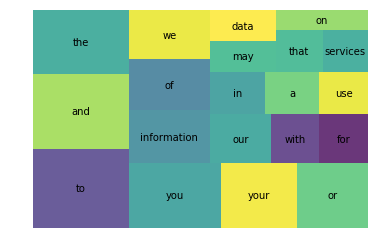

In [46]:
import squarify

wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

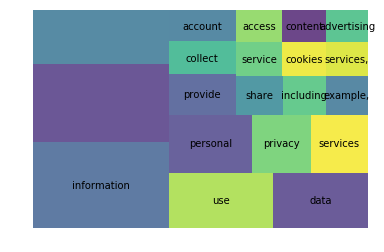

In [51]:
# omitting stop words
import spacy
from spacy.tokenizer import Tokenizer

import en_core_web_sm
nlp = en_core_web_sm.load()

STOP_WORDS = nlp.Defaults.stop_words.union(['\n', '\n \n', '\n\n'])

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)
tokens = []

""" Update those tokens """
for doc in tokenizer.pipe(web_info_df['Privacy_policy'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.is_stop == False) and (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)        
    
web_info_df['tokens'] = tokens
wc = count(web_info_df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [52]:
wc_top20

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
618,information,49,3172,1.0,0.034666,0.034666,1.000000
964,\n,47,2929,2.0,0.032011,0.066677,0.959184
977,\n\n,45,1975,3.0,0.021584,0.088261,0.918367
197,use,49,1569,4.0,0.017147,0.105409,1.000000
359,data,47,1435,5.0,0.015683,0.121092,0.959184
564,personal,46,1329,6.0,0.014524,0.135616,0.938776
210,privacy,48,932,7.0,0.010186,0.145802,0.979592
712,services,47,909,8.0,0.009934,0.155736,0.959184
113,provide,49,744,9.0,0.008131,0.163867,1.000000
558,collect,47,598,10.0,0.006535,0.170403,0.959184


In [33]:
# getting privacy policy text tokenized

docs = web_info_df["Privacy_policy"].values.tolist()

In [18]:
import gensim
from gensim.utils import simple_preprocess

def tokenize(doc):
    for doc in docs:
        yield(simple_preprocess(str(doc), deacc=True))

In [20]:
data_words = list(tokenize(docs))
data_words[0][:10]

['privacy',
 'policy',
 'last',
 'modified',
 'december',
 'view',
 'archived',
 'versions',
 'the',
 'hyperlinked']

In [21]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words = remove_stopwords(data_words)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', tokenizer=lambda doc: doc, lowercase=False)

dtm = tfidf.fit_transform(data_words)
df = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
df.head()

/Users/ljohnson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abandoning,abbot,abide,abides,ability,able,abn,aboutads,aboutcookies,absolute,...,youradchoices,youtube,yume,zealand,zillow,zip,zone,zoosk,zumobi,zune
0,0.0,0.0,0.0,0.0,0.006094,0.008222,0.0,0.0,0.0,0.0,...,0.0,0.084656,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.011678,0.015757,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.006170,0.008325,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.009838,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.021480,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.008143,0.016479,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.012983,0.0,0.0,0.0


In [23]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')

nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [24]:
sample_policy = ["We will sell your data to third parties. Nothing is secure. We do not care about your privacy"]

In [25]:
new = tfidf.transform(sample_policy)

nn.kneighbors(new.todense())

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[34, 27, 12, 31, 20, 38, 33,  1,  4, 30]]))

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

vect = TfidfVectorizer(stop_words='english', tokenizer=lambda doc: doc, lowercase=False)
sgdc = SGDClassifier()

pipe = Pipeline([('vect', vect), ('clf', sgdc)])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__max_iter':(20, 10, 100)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(data_words, web_info_df["Privacy"])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/ljohnson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.2s finished
/Users/ljohnson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/ljohnson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k',

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'clf__max_iter': (20, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [35]:
y_pred = grid_search.predict(sample_policy)
y_pred

array([1])